<a href="https://colab.research.google.com/github/xixihaha1995/esp_proj3/blob/main/ESP4T_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1-Connect to Google Drive

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import torch
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print('Please enter the path for project 3 codes:')
print('For example, /content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2024/')
#/content/drive/MyDrive/ESP 2022 Built Environment/Project 3/codes
#/content/drive/MyDrive/studying/Summer 2022/ESP 2022 Built Environment/Project 3/codes
#/content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2022/ESP2022_Project3_Answer_Instructor/
#/content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2024/
proj_path = str(input())
os.chdir(proj_path)
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please enter the path for project 3 codes:
For example, /content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2024/
/content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2024/
/content/drive/MyDrive/Archives/1_Studies/Semesters/Summer 2024


### 2-Read Excel file


Tabs are: Env.; Scale; 10mins;

1. We focus on the first 2 tabs
2. Then we need pre-process the Scale tab.
3. Combine the 2 tabs into one dataframe.


In [ ]:
inputExcel = 'ET_Experiment_Lettuce.xlsx'
xls = pd.ExcelFile(inputExcel)
#Valid date range is from April 17th, 2024 22:30 to April 26th, 2024 15:30
validIdx = 1254
df1 = pd.read_excel(xls, 'Env.')[0:validIdx]
df2 = pd.read_excel(xls, 'Scale')
diffLbs = df2['Weight (lbs)'].diff().fillna(0)
etMgS = np.where((diffLbs < 0) & (diffLbs > -1), abs(diffLbs * 453592.37 / (10 * 60)), 0)
#etMgS has more values than df1, so we need to trim it
df1['ET(mg/s)'] = etMgS[:len(df1)]

In [ ]:
print(df1.head())
print(df1.columns)

                Date   Temperature (C)  RH (%)  CO2 (ppm)  PPFD   ET(mg/s)
0 2024-04-17 22:30:00             19.0    74.0      295.0   0.0   0.000000
1 2024-04-17 22:40:00             19.0    74.0      286.0   0.0  13.076315
2 2024-04-17 22:50:00             20.0    74.0      268.0   0.0   2.275145
3 2024-04-17 23:00:00             19.0    74.0      256.0   0.0   9.079968
4 2024-04-17 23:10:00             19.0    74.0      250.0   0.0  19.434178
Index(['Date ', 'Temperature (C)', 'RH (%)', 'CO2 (ppm)', 'PPFD', 'ET(mg/s)'], dtype='object')


### 3-Explore variables related to evaporatranspiration (ET) process

'Date ', 'Temperature (C)', 'RH (%)', 'CO2 (ppm)', 'PPFD', 'ET(mg/s)'

PPFD stands for photosynthetic photon flux density.
It's a measurement of the amount of light that reaches a plant's leaves,
or other surface, within the PAR spectrum.
PPFD is expressed in micromoles per square meter per second (μmol/m²/s).

In [ ]:
selectedColumns = ['Date ', 'Temperature (C)', 'RH (%)', 'CO2 (ppm)', 'PPFD', 'ET(mg/s)']
plotDF = df1[selectedColumns]

In [ ]:
fig = px.line(plotDF, x='Date ', y= selectedColumns[1:])
fig.update_layout(
    title='Evaporatranspiration vs Related Factors (All in one y-axis)',
    xaxis_title='Date',
    yaxis_title='Variables',
    font=dict(
        family = "Times New Roman",
        size = 18,
        color = "Black"
    )
)
fig.show()

### 4-Potential correlation

In [ ]:
majorDepVar = 'ET(mg/s)'
suspectedIndVar = 'RH (%)' # 'Temperature (C)', 'RH (%)', 'CO2 (ppm)', 'PPFD'

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=plotDF['Date '], y=plotDF[suspectedIndVar], name=suspectedIndVar),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=plotDF['Date '], y=plotDF[majorDepVar], name=majorDepVar),
    secondary_y=True,
)

# Add figure title and labels
fig.update_layout(
    title='Evaporatranspiration vs Related Factors (In two y-axis)',
    xaxis_title='Date',
    yaxis_title=suspectedIndVar,
    font=dict(
        family="Times New Roman",
        size=18,
        color="Black"
    )
)

# Set y-axes titles
fig.update_yaxes(title_text=suspectedIndVar, secondary_y=False)
fig.update_yaxes(title_text=majorDepVar, secondary_y=True)

fig.show()

### 5-Correlation

In [ ]:
plotDFNoDate = plotDF.drop(columns=['Date '])

Pearson correlation is a measure of the linear relationship between two variables. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

To calculate the Pearson correlation coefficient ($r$) between two variables $X$ and $Y$, we use the following formula:

$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$

Where:

$x_i$ and $y_i$ are individual data points
$\bar{x}$ and $\bar{y}$ are the means of $X$ and $Y$, respectively
$n$ is the number of data points

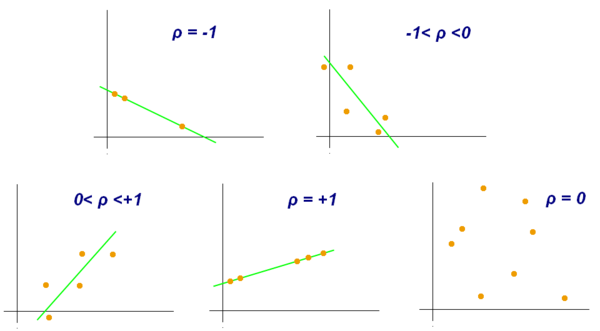

Correlation Matrix:
                 Temperature (C)    RH (%)  CO2 (ppm)      PPFD  ET(mg/s)
Temperature (C)         1.000000  0.047667  -0.331852  0.983843  0.613989
RH (%)                  0.047667  1.000000  -0.007374 -0.012333  0.162209
CO2 (ppm)              -0.331852 -0.007374   1.000000 -0.328803 -0.334481
PPFD                    0.983843 -0.012333  -0.328803  1.000000  0.565133
ET(mg/s)                0.613989  0.162209  -0.334481  0.565133  1.000000


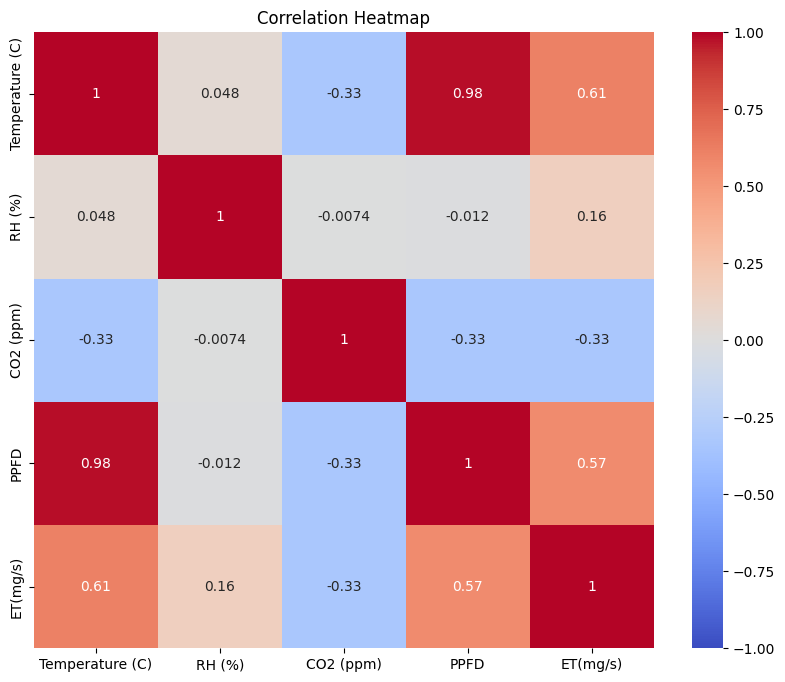

In [ ]:
# Calculate the correlation matrix
corr_matrix = plotDFNoDate.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


## 6-Linear Regression



### 6.1 Data processing

In [ ]:
def cvrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse / np.mean(y_true)

def inputOutputSplit(plotDFNoDate, parts=5):
    # Split data into 5 parts
    split_data = np.array_split(plotDFNoDate, parts)
    # Use the first 4 parts for training
    train_df = pd.concat(split_data[:parts - 1])
    # Use the last part for testing
    test_df = split_data[parts - 1]

    # Separate features and target variable in training data
    X_train = train_df.drop(columns=['ET(mg/s)']).values
    y_train = train_df['ET(mg/s)'].values

    # Separate features and target variable in testing data
    X_test = test_df.drop(columns=['ET(mg/s)']).values
    y_test = test_df['ET(mg/s)'].values

    # Normalize the features using the training data statistics
    mean_X = X_train.mean(axis=0)
    std_X = X_train.std(axis=0)

    X_train = (X_train - mean_X) / std_X
    X_test = (X_test - mean_X) / std_X

    # Normalize the target variable
    mean_y = y_train.mean()
    std_y = y_train.std()

    y_train = (y_train - mean_y) / std_y

    # Add a column of ones to X_train for the intercept term
    X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    # Add a column of ones to X_test for the intercept term
    X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

    return X_train_b, y_train, X_test_b, y_test, mean_y, std_y

def cvrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse / np.mean(y_true)

def plot_comparison(comparisonDF, cvrmsList, testDate):
    fig = px.line(comparisonDF, x=testDate, y=comparisonDF.columns)
    fig.update_layout(
        title='Prediction Performance',
        xaxis_title='Date',
        yaxis_title='ET(mg/s)',
        font=dict(
            family="Times New Roman",
            size=18,
            color="Black"
        )
    )

    for i, col in enumerate(comparisonDF.columns[1:]):
        cvrmse_value = cvrmsList[i]
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.05, y=0.95 - i * 0.05,
            text=f"{col}: CVRMSE = {cvrmse_value:.2f}%",
            showarrow=False,
            font=dict(
                family="Times New Roman",
                size=14,
                color="Black"
            )
        )

    fig.show()

### 6.2 Normal Equation in Linear Regression

The normal equation provides a direct method to find the optimal parameters (coefficients) for a linear regression model by minimizing the cost function. Here's a brief introduction and derivation process for the normal equation.

#### Linear Regression Model
In linear regression, we model the relationship between the input features $ \mathbf{X} $ and the output $ \mathbf{y} $ using the equation:

$\mathbf{y} = \mathbf{X} \beta + \epsilon $

where:
- $ \mathbf{y} $ is the vector of observed values.
- $ \mathbf{X} $ is the matrix of input features.
- $ \beta $ is the vector of coefficients to be estimated.
- $ \epsilon $ is the error term.

#### Cost Function
The cost function $ J(\beta) $, often the Mean Squared Error (MSE), measures the difference between the observed values and the values predicted by the model:

$ J(\beta) = \frac{1}{2m} \sum_{i=1}^{m} (y^{(i)} - X^{(i)} \beta)^2 $

where $ m $ is the number of training examples.

#### Derivation of the Normal Equation
To minimize the cost function, we take its derivative with respect to $ \beta $ and set it to zero. The cost function in matrix form is:

$ J(\beta) = \frac{1}{2m} ( \mathbf{y} - \mathbf{X} \beta )^T ( \mathbf{y} - \mathbf{X} \beta ) $

1. **Expand the quadratic form**:

$ J(\beta) = \frac{1}{2m} ( \mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \beta + \beta^T \mathbf{X}^T \mathbf{X} \beta ) $

2. **Take the derivative with respect to $ \beta $**:

$ \frac{\partial J(\beta)}{\partial \beta} = \frac{1}{m} (- \mathbf{X}^T \mathbf{y} + \mathbf{X}^T \mathbf{X} \beta ) $

3. **Set the derivative to zero**:

$ \mathbf{X}^T \mathbf{X} \beta = \mathbf{X}^T \mathbf{y} $

4. **Solve for $ \beta $**:

$ \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $

This equation, known as the **normal equation**, provides the closed-form solution for the coefficients $ \beta $.

#### Why Not Directly Multiply $ \mathbf{X}^{-1} $?
Directly multiplying by $ \mathbf{X}^{-1} $ is not feasible for several reasons:

1. **Non-Square Matrix**: In most cases, $ \mathbf{X} $ is not a square matrix (it has more rows than columns), so $ \mathbf{X}^{-1} $ does not exist.
2. **Non-Invertibility**: Even if $ \mathbf{X} $ were square, it might not be invertible (i.e., it could be singular or nearly singular), making $ \mathbf{X}^{-1} $ undefined or unstable.
3. **Numerical Stability**: $ \mathbf{X}^T \mathbf{X} $ is more likely to be invertible and better conditioned than $ \mathbf{X} $, ensuring more stable and reliable calculations.

### Summary
The normal equation $ \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $ is derived by minimizing the cost function and provides a direct solution for the coefficients in linear regression. This method avoids the pitfalls of directly inverting $ \mathbf{X} $ and ensures numerical stability and feasibility.

For further details, you can refer to the following sources:
- [Andrew Ng's Machine Learning Course on Coursera](https://www.coursera.org/learn/machine-learning/lecture/OEpFA/linear-regression-with-one-variable)
- [Wikipedia: Normal Equation](https://en.wikipedia.org/wiki/Normal_equation)
- [Stanford University: Linear Regression](https://web.stanford.edu/class/archive/cs/cs109/cs109.1192/lectures/lecture12/12-NormalEquation.pdf)

In [ ]:
def normalEquation(X_train_b, y_train):
    # Compute the normal equation: beta = (X_train_b.T * X_train_b)^(-1) * X_train_b.T * y_train
    beta = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)
    return beta

X_train_b, y_train, X_test_b, y_test, mean_y, std_y = inputOutputSplit(plotDFNoDate)
testDate = plotDF['Date '].values[-len(y_test):]
beta = normalEquation(X_train_b, y_train)
# Predict the target variable in the testing data
y_pred_NE = X_test_b.dot(beta) * std_y + mean_y

In [ ]:
comparisionDF = pd.DataFrame({'Actual': y_test, 'Predicted-NormalEquation': y_pred})
cvrmseNE = cvrmse(y_test, y_pred_NE)
cvrmsList = [cvrmseNE]

plot_comparison(comparisionDF, cvrmsList,testDate)

### 6.3 Polynomial Regression

While linear regression models a linear relationship between the dependent and independent variables, polynomial regression extends this to model non-linear relationships. It achieves this by adding polynomial terms (squares, cubes, etc.) of the independent variables to the regression equation.

Despite using polynomial terms, polynomial regression is still considered a linear regression model. This is because the model is linear in the coefficients, even though the relationship with the independent variable is non-linear.

For example, a polynomial regression model of degree 2 would look like:

$y = \beta_0 + \beta_1 x + \beta_2 x^2$

Here, the model is linear in the coefficients $\beta_0$, $\beta_1$, and $\beta_2$, but non-linear in the independent variable $x$ due to the $x^2$ term.

By adding polynomial terms, polynomial regression can capture more complex relationships between variables compared to simple linear regression, leading to better model fit in certain cases.

In [ ]:
# Create polynomial features up to degree 3
def create_polynomial_features(df, degree=3):
    df_poly = df.copy()
    for power in range(2, degree + 1):
        for col in df.columns:
            if col != 'ET(mg/s)':
                new_col_name = f"{col}^{power}"
                df_poly[new_col_name] = df[col] ** power
    return df_poly

plotDFPoly = create_polynomial_features(plotDFNoDate)
X_train_b, y_train, X_test_b, y_test, mean_y, std_y = inputOutputSplit(plotDFPoly)
beta = normalEquation(X_train_b, y_train)

# Predict the target variable in the testing data
y_pred_poly = X_test_b.dot(beta) * std_y + mean_y
comparisionDF['Predicted-Polynomial'] = y_pred_poly
cvrmsePoly = cvrmse(y_test, y_pred_poly)
cvrmsList.append(cvrmsePoly)
plot_comparison(comparisionDF, cvrmsList, testDate)

## 7-Introduction to Gradient Descent for Non-Linear Models

#### Increasing Non-Linearity

As we incorporate more complex and non-linear terms into our models, such as polynomial terms or functions like $\sin(x_1)$, $e^{x_2}$, or $x_1 \cdot x_2$, the model's complexity increases. These terms can capture intricate relationships in the data, providing more flexibility and potentially better predictive performance. However, this complexity comes at a cost.

### Challenges with the Normal Equation

The normal equation provides a closed-form solution for linear regression, which works well for linear models and polynomial regression up to a certain degree. The normal equation is:

$ \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $

This method works efficiently for linear and simple polynomial terms. However, for more complex and highly non-linear models, the normal equation becomes impractical due to:

1. **Matrix Inversion Issues**: Inverting $(\mathbf{X}^T \mathbf{X})$ becomes computationally expensive and numerically unstable as the feature matrix $\mathbf{X}$ grows in size and complexity.
2. **Non-Linear Functions**: For functions like $\sin(x_1)$ or $e^{x_2}$, the relationship between features and the target variable is no longer linear, making the normal equation unsuitable.

#### Gradient Descent Algorithm

Gradient descent is a powerful optimization algorithm that can handle complex and non-linear models. Unlike the normal equation, gradient descent iteratively adjusts the model parameters to minimize the cost function.

Gradient descent works by computing the gradient (partial derivatives) of the cost function with respect to the model parameters and updating the parameters in the direction that decreases the cost function.

1. **Initialize Parameters**: Start with random values for the model parameters $\beta$.

2. **Compute Predictions**: Calculate the predicted values $\hat{y}$ using the current parameters.

3. **Compute Cost Function**: Calculate the cost function (e.g., Mean Squared Error, MSE).

$ J(\beta) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2 $

4. **Compute Gradients**: Compute the gradient of the cost function with respect to each parameter.

$ \frac{\partial J(\beta)}{\partial \beta_j} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) x_j^{(i)} $

5. **Update Parameters**: Update the parameters using the gradients and the learning rate $\alpha$.

$ \beta_j := \beta_j - \alpha \frac{\partial J(\beta)}{\partial \beta_j} $

6. **Repeat**: Repeat steps 2-5 for a specified number of iterations or until convergence.


### References
- [Andrew Ng's Machine Learning Course on Coursera](https://www.coursera.org/learn/machine-learning/lecture/OEpFA/linear-regression-with-one-variable)
- [Wikipedia: Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)
- [Stanford University: Machine Learning](https://web.stanford.edu/class/cs229/lectures/cs229-notes1.pdf)

#### 7.1 Manual Gradient Descent Algorithm

1. **Initialize**: $\beta = \text{randn}(n)$
2. **Loop** (for $t = 1$ to 2000):
   - Compute $\hat{y} = X \beta$
   - Compute Loss: $ \text{Loss} = \sum (\hat{y} - y)^2 $
   - Compute Gradients for $\hat{y}$: $grad_{\hat{y}} = 2 (\hat{y} - y)$
   - Compute Gradients for $\beta$: $grad_{\beta} = X^T \times grad_{\hat{y}}$

   - Update Weights: $\beta = \beta - \alpha \cdot grad_{\beta}$

This process is repeated for a specified number of epochs to minimize the loss and find the optimal $\beta$ values for the polynomial regression model.

In [ ]:
def manualGD(X_train_b, y_train, learning_rate=1e-6, epochs=2000, random_seed=42):
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Initialize weights randomly
    num_features = X_train_b.shape[1]
    beta = np.random.randn(num_features)

    for t in range(epochs):
        # Forward pass: compute predicted y
        y_pred = X_train_b.dot(beta)

        # Compute loss
        loss = np.sum((y_pred - y_train) ** 2)
        if t % 500 == 499:
            print(f'Epoch #{t + 1}, loss: {loss:.2f}')

        # Compute gradients explicitly for each term
        grad_y_pred = 2.0 * (y_pred - y_train)

        # Compute gradients for each feature
        grad_beta = X_train_b.T.dot(grad_y_pred)

        # Update weights using gradient descent
        beta -= learning_rate * grad_beta

    return beta

In [ ]:
X_train_b, y_train, X_test_b, y_test, mean_y, std_y = inputOutputSplit(plotDFPoly)
beta = manualGD(X_train_b, y_train, learning_rate=1e-6, epochs=2000, random_seed=42)
y_pred_poly_manualGD = X_test_b.dot(beta) * std_y + mean_y
comparisionDF['Predicted-Polynomial-ManualGD'] = y_pred_poly_manualGD
cvrmsePoly_manualGD = cvrmse(y_test, y_pred_poly_manualGD)
cvrmsList.append(cvrmsePoly_manualGD)
plot_comparison(comparisionDF, cvrmsList, testDate)

Epoch #500, loss: 680.95
Epoch #1000, loss: 624.50
Epoch #1500, loss: 615.44
Epoch #2000, loss: 610.22


#### 7.2 Mini-Batch Gradient Descent

Mini-Batch Gradient Descent (MBGD) is a variant of the traditional Gradient Descent algorithm that combines elements of both Stochastic Gradient Descent (SGD) and Batch Gradient Descent (BGD). It offers a balance between the stability of Batch Gradient Descent and the speed of Stochastic Gradient Descent.

#### Comparison with Manual (Batch) Gradient Descent

**Manual Gradient Descent (Batch Gradient Descent)**
- **Update Frequency**: In Batch Gradient Descent, the model parameters are updated only after computing the gradient of the entire dataset.
- **Stability**: This method provides stable updates because it uses the complete dataset to compute the gradients, leading to smooth convergence.
- **Computationally Expensive**: Since it processes the entire dataset for each update, it can be very slow and computationally intensive, especially for large datasets.

**Mini-Batch Gradient Descent**
- **Update Frequency**: In Mini-Batch Gradient Descent, the model parameters are updated after computing the gradient on small random subsets (mini-batches) of the dataset.
- **Balance Between Speed and Stability**: It provides a compromise between the fast but noisy updates of Stochastic Gradient Descent and the slow but stable updates of Batch Gradient Descent.
- **Efficiency**: By using mini-batches, it reduces the variance of the parameter updates, leading to more stable convergence compared to SGD, and it is faster than BGD as it processes smaller subsets of the dataset at each step.

#### Key Points of Mini-Batch Gradient Descent
- **Mini-Batches**: The dataset is divided into small random mini-batches, each containing a subset of the training examples.
- **Frequent Updates**: Parameters are updated more frequently compared to Batch Gradient Descent, improving convergence speed.
- **Less Variance**: The averaging effect of mini-batches reduces the noise in the updates compared to Stochastic Gradient Descent.
- **Parallelism**: Mini-batch updates can take advantage of hardware acceleration (e.g., GPUs), making it suitable for large-scale machine learning tasks.

### Summary of Mini-Batch Gradient Descent Steps
1. **Initialize Parameters**: Start with random values for the model parameters $\beta$.
2. **Divide Data into Mini-Batches**: Split the training dataset into small random mini-batches.
3. **Iterate Over Mini-Batches**: For each mini-batch, perform the following steps:
   - **Compute Predictions**: Calculate predicted values $\hat{y}$ for the mini-batch.
   - **Compute Cost Function**: Calculate the cost (e.g., Mean Squared Error) for the mini-batch.
   - **Compute Gradients**: Compute the gradients of the cost function with respect to the parameters using the mini-batch data.
   - **Update Parameters**: Update the parameters using the computed gradients.
4. **Repeat**: Repeat the process for a specified number of epochs or until convergence.

### Advantages of Mini-Batch Gradient Descent
- **Faster Convergence**: More frequent updates can lead to faster convergence.
- **Reduced Memory Requirements**: Processes smaller subsets of the data, requiring less memory.
- **Improved Generalization**: The noise introduced by mini-batches can help the model generalize better to new data.

By incorporating the principles of both Batch Gradient Descent and Stochastic Gradient Descent, Mini-Batch Gradient Descent provides an efficient and scalable optimization method suitable for modern machine learning tasks, especially when dealing with large datasets and complex models.

In [ ]:
def gradientDescent(X_train_b, y_train, learning_rate=1e-6, epochs=2000, batch_size=32, random_seed=42):
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)

    # Convert numpy arrays to torch tensors
    X_train_b = torch.tensor(X_train_b, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Initialize weights randomly
    num_features = X_train_b.shape[1]
    beta = torch.randn(num_features, dtype=torch.float32, requires_grad=True)

    # Training with SGD
    dataset = torch.utils.data.TensorDataset(X_train_b, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            # Forward pass: compute predicted y
            y_pred = X_batch.mm(beta.unsqueeze(1)).squeeze()

            # Compute loss
            loss = (y_pred - y_batch).pow(2).sum()
            total_loss += loss.item()

            # Backprop to compute gradients
            loss.backward()

            # Update weights using gradient descent
            with torch.no_grad():
                beta -= learning_rate * beta.grad
                beta.grad.zero_()

        if epoch % 250 == 249:  # Adjust frequency of printing
            print(f'Epoch #{epoch + 1}, loss: {total_loss:.2f}')

    return beta.detach().numpy()

In [ ]:
X_train_b, y_train, X_test_b, y_test, mean_y, std_y = inputOutputSplit(plotDFPoly)
beta = gradientDescent(X_train_b, y_train, learning_rate=1e-6, epochs=1000, batch_size=10, random_seed=42)
y_pred_poly_GD = X_test_b.dot(beta) * std_y + mean_y
comparisionDF['Predicted-Polynomial-GD'] = y_pred_poly_GD
cvrmsePoly_GD = cvrmse(y_test, y_pred_poly_GD)
cvrmsList.append(cvrmsePoly_GD)
plot_comparison(comparisionDF, cvrmsList, testDate)

Epoch #250, loss: 1064.69
Epoch #500, loss: 647.25
Epoch #750, loss: 613.05
Epoch #1000, loss: 604.27


## 8-Neural network

### 8.1 One hidden layer neural network
A neural network is a network or circuit of biological neurons, or, in a modern sense, an artificial neural network, composed of artificial neurons or nodes. Thus, a neural network is either a **biological** neural network, made up of biological neurons, or an **artificial** neural network, used for solving artificial intelligence (AI) problems.<br>

**Watch the video**(After introducing layers).https://www.youtube.com/watch?v=aircAruvnKk&t=915s</br>
**Quiz:**</br>
Please denote the position of "neuron/nodes" in the following figure. </br>
**Quiz:**</br>
Please denote the position of "Hidden Layer" in the following figure. </br>

![Traditional neural network](https://drive.google.com/uc?export=view&id=1gQoLLUb8u4ZSWAzTenykECongVTcxNi-)</br>

Some [common activation](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) functions:<br>


1.   Identity. $Identity(x) = x$
2.   Binary step. $Binary_{step}(x) = \begin{cases}
      0 & x\leq 0 \\
      1 & x > 0
   \end{cases}$
3. Logistic(or sigmoid, $σ$, soft step). $\sigma(x) = \frac{1}{1+e^{-x}}$
4. Softmax. $Softmax(z)_i = \frac{e^{z_i}}{\sum_{j = 1}^{K}e^{z_j}}$
5. Others (**ReLU**, **tanh**):
![Common activation functions](https://drive.google.com/uc?export=view&id=1xe8pJv_gAm0kIBgccWVZa0UCD1t56_Kh)

### 8.2 Recurrent neural network
References: [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by colah'blog.<br>
#### Traditional neural network vs Recurrent neural network
1. Traditional neural network **cannot** use previous events to inform later ones. TO be specific, traditional neural network will integrate all the information from initial time till the end time.</br>
![Traditional neural network](https://drive.google.com/uc?export=view&id=1gQoLLUb8u4ZSWAzTenykECongVTcxNi-)
2. Recurrent neural networks address this issue. RNN allow information from the past to persist.
![An unrolled recurrent neural network.](https://drive.google.com/uc?export=view&id=1CWZjuBwIiA50s6dEUki_CJNgeX7h27Ue)

### 8.3 LSTM and GRU
**The problem of long-term dependecies.** </br>
Sometimes, we only need to look at recent information to perform the present task. For example, if we are trying to predict the last word in "the clouds are in the ***__***", it's pretty obvious the word is going to be ***sky***.<br>
Unfortunately, as the gap between the relevant information and the place that it's needed grows, RNNs become unable to learn to connect the information. For example, trying to predict the last word in the text “I grew up in France… I speak fluent ***French***.”

Watch this video. [Illustrated Guide to LSTM's and GRU's: A step by step explanation](https://www.youtube.com/watch?v=8HyCNIVRbSU). </br>
**Quiz 1.**</br>
Why should we use RNN instead of the traditonal neural network (such as the one hidden layer neural network)? </br>
**Quiz 2**</br>
Compared with Vanilla RNN, why are LSTM or GRU better at short-term memory?</br>
**Quiz 3**</br>
Which of the following are GRU cells?
![? structure](https://drive.google.com/uc?export=view&id=1a3mEns6mvwkySJ0bdcYgJimwKBHzBgfg)
![? structure](https://drive.google.com/uc?export=view&id=13fNKVSLdTJctnw5vM8wYQljJPA-NlJEq)
![? structure](https://drive.google.com/uc?export=view&id=1_Uc6o7v1u_7ea1szvAV5ABjs74-mkTbt)

### 8.4 Prediction performance comparison

In [ ]:
import plotly.express as px
cvrmse_oneHiddenLayer = cvrmses['OneHiddenLayer']
cvrmse_LSTM = cvrmses['LSTM']
cvrmse_GRU = cvrmses['GRU']
fig = px.line(dataset, x="Date", y=["Measured",'OneHiddenLayer','LSTM','GRU'])
fig.update_layout(
     title=f"Prediction Performance (CVRMSE) <br>"
     f"OneHiddenLayer:<b>{cvrmse_oneHiddenLayer:.2f}</b>%;"
     f"LSTM:<b>{cvrmse_LSTM:.2f}</b>%;"
     f"GRU:<b>{cvrmse_GRU:.2f}</b>%",
     yaxis_title="HVAC Electricity Consumption[J]",
     legend_title="Energy types",
     font=dict(
         family="Times New Roman",
         size=12,
         color="Black"
         )
     )
fig.show()